In [26]:
from ctapipe.io import read_table
from ctapipe.instrument import SubarrayDescription
from ctapipe.visualization import CameraDisplay

from lstchain.io.io import dl1_params_lstcam_key, dl1_images_lstcam_key
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

%matplotlib inline

In [27]:
# Read one example MC gamma DL1 file:
dl1_file = "/fefs/aswg/workspace/analysis-school-2022/DL1ab/dl1_gamma_20deg_180deg_run10___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_off0.4.h5"

# Show where the images (DL1a) are stored in the hdf5 files:
print(dl1_images_lstcam_key)
# read images table:
dl1_images = read_table(dl1_file, dl1_images_lstcam_key)

# Show where the image parameters (DL1b) are stored in the hdf5 files:
print(dl1_params_lstcam_key)
# read parameters table:
dl1_parameters = read_table(dl1_file, dl1_params_lstcam_key)

/dl1/event/telescope/image/LST_LSTCam
/dl1/event/telescope/parameters/LST_LSTCam


In [28]:
subarray_info = SubarrayDescription.from_hdf(dl1_file) # Read instrument description
camgeom = subarray_info.tel[1].camera.geometry

         x                    y                  psi               width               length      
         m                    m                  rad                deg                 deg        
-------------------- ------------------- ------------------- ------------------ -------------------
-0.20680395958314557 0.35769059784649504 -0.7084927218832158 0.1443594054741513 0.45317692509635227


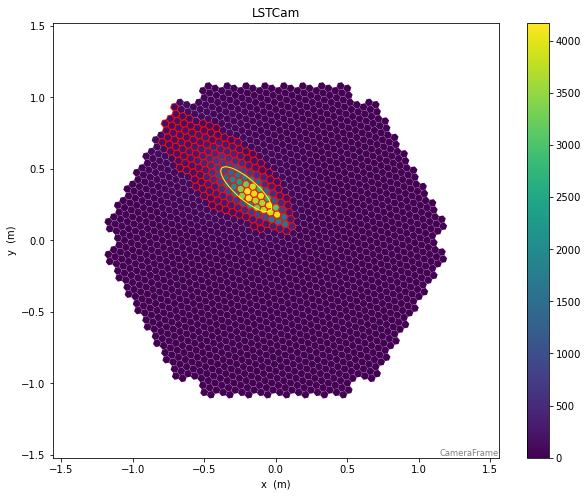

In [29]:
# Locate first table entry for which n_pixels (after cleaning) is larger than 100, 
# is more or less centered (c.o.g. within 0.5 m of the camera center), and is a cosmic (="SUBARRAY"):
mask = ((dl1_parameters['n_pixels']>100) & 
        (dl1_parameters['r']<0.5*u.m)
       )

index = np.where(mask)[0][0]

plt.figure(figsize=(10,8))

camdisplay = CameraDisplay(camgeom, dl1_images['image'][index])
cleanmask = dl1_images['image_mask'][index]


camdisplay.highlight_pixels(cleanmask, color='red')

camdisplay.add_ellipse((dl1_parameters['x'][index], dl1_parameters['y'][index]), 
                       dl1_parameters['length'][index], dl1_parameters['width'][index],
                       dl1_parameters['psi'][index], color='yellow')



print(dl1_parameters['x','y', 'psi', 'width', 'length'][index])

camdisplay.add_colorbar()
plt.show()